# Neo4j와 LangChain을 활용한 Knowledge Graph

## 1. 환경 설정

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_neo4j import Neo4jGraph

# LangChain 도구 활용 - DB 연결 객체 초기화
# Neo4jGraph 클래스는 LangChain 라이브러리에서 제공하는 Neo4j 그래프 데이터베이스 연결 도구입니다.
# 이 객체를 통해 Cypher 쿼리를 실행하고 그래프 데이터를 조작할 수 있습니다.
graph = Neo4jGraph(
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD"),
)
graph

In [ ]:
# 테스트 쿼리 실행 - Neo4j 연결이 제대로 작동하는지 확인하기 위한 간단한 테스트
# Cypher 쿼리를 사용하여 Test 레이블을 가진 노드를 생성하고 반환합니다
cypher_query = """
CREATE (n:Test {name: "Hello AuraDB"})
RETURN n
"""

# graph.query() 메서드를 사용하여 Cypher 쿼리를 실행합니다
# CREATE 구문은 새 노드를 생성하고, RETURN은 생성된 노드를 결과로 반환합니다
# 이 쿼리가 성공적으로 실행되면 Neo4j 데이터베이스 연결이 정상적으로 작동하는 것입니다
graph.query(cypher_query)

[{'n': {'name': 'Hello AuraDB'}}]

In [ ]:
def reset_database(graph):
    """
    데이터베이스 초기화하기
    """
    # 모든 노드와 관계 삭제
    graph.query("MATCH (n) DETACH DELETE n")

    # 모든 제약조건 삭제
    constraints = graph.query("SHOW CONSTRAINTS")
    for constraint in constraints:
        constraint_name = constraint.get("name")
        if constraint_name:
            graph.query(f"DROP CONSTRAINT {constraint_name}")

    # 모든 인덱스 삭제
    indexes = graph.query("SHOW INDEXES")
    for index in indexes:
        index_name = index.get("name")
        index_type = index.get("type")
        if index_name and index_type != "CONSTRAINT":
            graph.query(f"DROP INDEX {index_name}")

    print("데이터베이스가 초기화되었습니다.")


# 데이터베이스 초기화
reset_database(graph)

---

## 2. Cypher Query Basic

Cypher는 Neo4j의 그래프 쿼리 언어로, 그래프 패턴을 시각적으로 표현하는 문법을 제공합니다.

#### 1. 기본 문법 사용법

- **노드 표현**: 괄호 `()` 사용
   ```cypher
   (n)                     // 모든 노드
   (p:Person)              // Person 레이블을 가진 노드
   (m {name: "Neo4j"})     // name 속성이 "Neo4j"인 노드
   (p:Person {age: 30})    // Person 레이블과 age 속성을 가진 노드
   ```

In [5]:
# Neo4j 데이터베이스에 노드 생성하기 (CREATE 구문 사용)
# CREATE 구문은 새로운 노드나 관계를 생성할 때 사용하는 기본 명령어입니다.
# 동일한 노드가 이미 존재해도 "중복 생성"되므로 주의해야 합니다.
cypher_query = """
// 노드 레이블 : Person (사람을 나타내는 레이블)
// 노드 속성 정의:
//   - name: "전현준" (이름)
//   - age: 35 (나이)
//   - email: "jeonhj92@gmail.com" (이메일 주소)
// p는 생성된 노드를 참조하는 변수명입니다.
CREATE (p:Person {name: "전현준", age: 35, email: "jeonhj920@gmail.com"})
"""

# graph.query()를 사용하여 Cypher 쿼리를 실행합니다.
# 이 명령은 Neo4j 데이터베이스에 실제로 노드를 생성합니다.
graph.query(cypher_query)

[]

In [6]:
# CREATE 구문을 사용하여 여러 노드를 한 번에 생성할 수 있습니다.
cypher_query = """
// 노드 레이블 정의:
//   - Person: 사람을 나타내는 레이블
//   - City: 도시를 나타내는 레이블
//
// Person 노드 속성 정의:
//   - name: 사람의 이름 (문자열)
//   - age: 사람의 나이 (숫자)
//
// City 노드 속성 정의:
//   - name: 도시 이름 (문자열)
//   - population: 인구수 (숫자)
//
// 변수 a, b, c는 각각 생성된 노드를 참조하는 변수명입니다.
CREATE
  (a:Person {name: "이삼성", age: 30}),
  (b:Person {name: "박사성", age: 40}),
  (c:City {name: "서울", population: 9800000})
"""
# graph.query()를 사용하여 Cypher 쿼리를 실행합니다.
# 이 명령은 Neo4j 데이터베이스에 세 개의 노드를 한 번에 생성합니다.
graph.query(cypher_query)

[]

- **관계 표현**: 대시와 대괄호 `-[]->` 사용
   ```cypher
   -->                     // 모든 관계
   -[r:KNOWS]->            // KNOWS 타입의 관계
   -[r:LIKES {since: 2020}]->  // 속성을 가진 관계
   <-[r:FOLLOWS]-          // 방향이 반대인 관계
   -[r:FRIENDS|KNOWS]->    // 여러 타입의 관계(OR 조건)
   ```

In [7]:
# 기존 노드 사이에 관계 생성하기
cypher_query = """
// 관계 레이블 : KNOWS (알고 있다는 관계를 나타냄)
// 관계 속성 : since (관계가 시작된 시점을 나타내는 속성)
// 관계 방향 : a -> b (홍길동이 김철수를 알고 있는 방향성)
// 관계 속성 값: since: 2020 (2020년부터 관계가 시작됨)
// 관계 생성 의미 : 홍길동은 김철수를 2020년부터 알게 됨

// MATCH 구문으로 두 개의 기존 노드를 찾음
MATCH
  (a:Person {name: "이삼성"}),  // Person 레이블을 가진 이름이 홍길동인 노드를 찾아 변수 a에 할당
  (b:Person {name: "박사성"})   // Person 레이블을 가진 이름이 김철수인 노드를 찾아 변수 b에 할당

// CREATE 구문으로 두 노드 사이에 방향성 있는 관계 생성
CREATE (a)-[r:KNOWS {since: 2020}]->(b)  // a에서 b로 향하는 KNOWS 타입의 관계 r 생성, since 속성 추가

// RETURN 구문으로 노드와 관계 정보 반환
RETURN a, b, r  // 생성된 관계와 연결된 두 노드 정보를 함께 반환
"""
# Neo4j 데이터베이스에 Cypher 쿼리를 실행하여 두 노드 간 관계를 생성
graph.query(cypher_query)

[{'a': {'name': '이삼성', 'age': 30},
  'b': {'name': '박사성', 'age': 40},
  'r': ({'name': '이삼성', 'age': 30}, 'KNOWS', {'name': '박사성', 'age': 40})}]

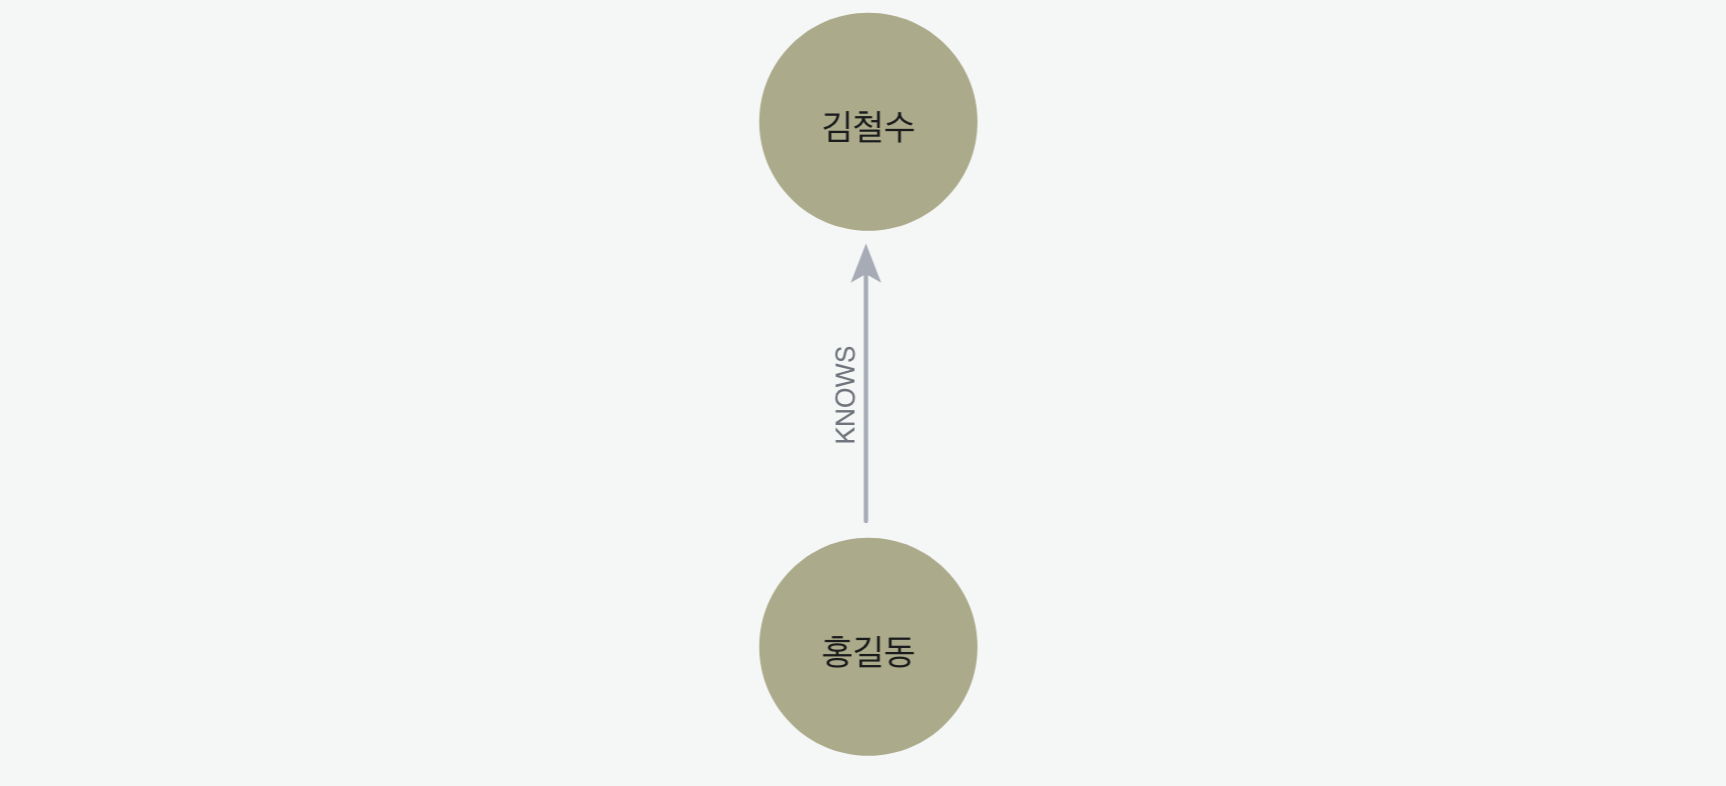

In [8]:
# TODO: 처음에 만든 Person노드가 이삼성을 1980년 부터 알고 있었다를 관계로 맺어주세요.
cypher_query = """
MATCH
  (a:Person {name: "이삼성"}),
  (b:Person {name: "전현준"})

CREATE (b)-[r:KNOWS {since: 1980}]->(a)
"""
graph.query(cypher_query)

[]

In [9]:
# 노드와 관계를 한 번에 생성하는 Cypher 쿼리
cypher_query = """
// 노드 레이블 : Person, City (각각 사람과 도시를 나타내는 레이블)
// CREATE 구문으로 노드와 관계를 동시에 생성
CREATE
  // a 변수에 Person 레이블을 가진 노드 생성, 속성으로 name="박지성" 설정
  (a:Person {name: "박지성"})-[:LIVES_IN]->
  // c 변수에 City 레이블을 가진 노드 생성, 속성으로 name="맨체스터" 설정
  // LIVES_IN 관계는 '살고 있다'는 의미로 박지성이 맨체스터에 거주함을 나타냄
  (c:City {name: "맨체스터"})
// RETURN 구문으로 생성된 두 노드 정보 반환
RETURN a, c
"""
# Neo4j 데이터베이스에 Cypher 쿼리를 실행하여 노드와 관계를 동시에 생성
graph.query(cypher_query)

[{'a': {'name': '박지성'}, 'c': {'name': '맨체스터'}}]

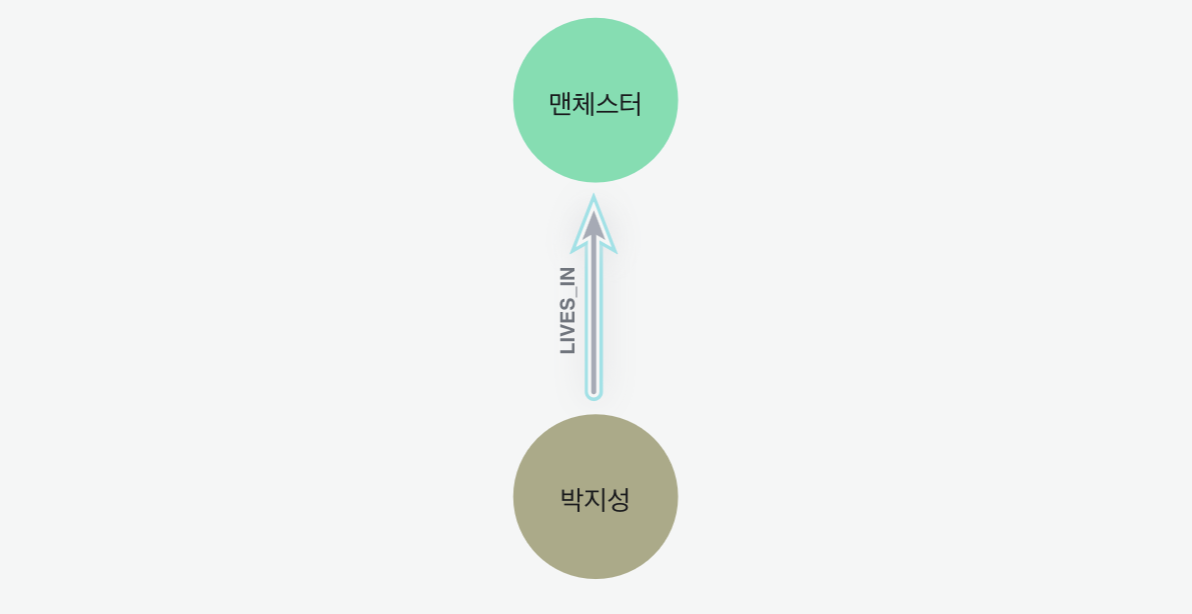

In [10]:
# 기존에 생성된 노드들 사이에 관계를 추가하는 Cypher 쿼리
cypher_query = """
// 관계 레이블 : LIVES_IN (거주한다는 의미의 관계 타입)
// 관계 방향 : a -> c (이영희가 서울에 산다는 방향성)
// 관계 속성 : since: 2020 (2020년부터 관계가 시작됨)
// 관계 생성 의미 : 이영희는 서울에 2020년부터 거주하기 시작함

// MATCH 구문으로 두 개의 기존 노드를 찾음
MATCH
  (a:Person {name: "전현준"}),  // Person 레이블을 가진 이름이 이영희인 노드를 찾아 변수 a에 할당
  (c:City {name: "서울"})       // City 레이블을 가진 이름이 서울인 노드를 찾아 변수 c에 할당

// CREATE 구문으로 두 노드 사이에 방향성 있는 관계 생성
CREATE (a)-[r:LIVES_IN {since: 2000}]->(c)  // a에서 c로 향하는 LIVES_IN 타입의 관계 r 생성, since 속성 추가

// RETURN 구문으로 노드와 관계 정보 반환
RETURN a, c, r  // 생성된 관계와 연결된 두 노드 정보를 함께 반환
"""
# Neo4j 데이터베이스에 Cypher 쿼리를 실행하여 두 노드 간 관계를 생성
graph.query(cypher_query)

[{'a': {'name': '전현준', 'email': 'jeonhj920@gmail.com', 'age': 35},
  'c': {'name': '서울', 'population': 9800000},
  'r': ({'name': '전현준', 'email': 'jeonhj920@gmail.com', 'age': 35},
   'LIVES_IN',
   {'name': '서울', 'population': 9800000})}]

In [11]:
# 기존에 생성된 노드들 사이에 여러 관계를 추가하는 Cypher 쿼리
cypher_query = """
// 첫 번째 관계 정보
// 관계 레이블 : LIVES_IN (거주한다는 의미의 관계 타입)
// 관계 방향 : a -> c (홍길동이 서울에 산다는 방향성)
// 관계 속성 : since: 2010 (2010년부터 관계가 시작됨)
// 관계 생성 의미 : 홍길동은 서울에 2010년부터 거주하기 시작함

// 두 번째 관계 정보
// 관계 레이블 : KNOWS (안다/알고 있다는 의미의 관계 타입)
// 관계 방향 : a -> b (홍길동이 박지성을 안다는 방향성)
// 관계 속성 : since: 2020 (2020년부터 관계가 시작됨)
// 관계 생성 의미 : 홍길동은 박지성을 2020년부터 알게 됨

// 세 번째 관계 정보
// 관계 레이블 : KNOWS (안다/알고 있다는 의미의 관계 타입)
// 관계 방향 : b -> a (박지성이 홍길동을 안다는 방향성)
// 관계 속성 : since: 2020 (2020년부터 관계가 시작됨)
// 관계 생성 의미 : 박지성은 홍길동을 2020년부터 알게 됨
// 두 번째와 세 번째 관계를 통해 양방향 관계(b <-> a)를 표현함

// MATCH 구문으로 세 개의 기존 노드를 찾음
MATCH
  (a:Person {name: "이삼성"}),  // Person 레이블을 가진 이름이 홍길동인 노드를 찾아 변수 a에 할당
  (b:Person {name: "박지성"}),  // Person 레이블을 가진 이름이 박지성인 노드를 찾아 변수 b에 할당
  (c:City {name: "서울"})       // City 레이블을 가진 이름이 서울인 노드를 찾아 변수 c에 할당

// CREATE 구문으로 노드들 사이에 방향성 있는 관계 생성
CREATE (a)-[r1:LIVES_IN {since: 2010}]->(c)  // a에서 c로 향하는 LIVES_IN 타입의 관계 r1 생성, since 속성 추가
CREATE (a)-[r2:KNOWS {since: 2020}]->(b)     // a에서 b로 향하는 KNOWS 타입의 관계 r2 생성, since 속성 추가
CREATE (b)-[r3:KNOWS {since: 2020}]->(a)     // b에서 a로 향하는 KNOWS 타입의 관계 r3 생성, since 속성 추가
"""
# Neo4j 데이터베이스에 Cypher 쿼리를 실행하여 여러 노드 간 관계를 생성
graph.query(cypher_query)

[]

3. **변수 할당**: 노드나 관계에 변수 할당 (나중에 참조할 수 있음)
   ```cypher
   (p:Person)      // p 변수에 Person 노드 할당
   -[r:KNOWS]->    // r 변수에 KNOWS 관계 할당
   ```

In [ ]:
# 노드 조회 (RETURN 구문)
cypher_query = """
// Person 레이블을 가진 모든 노드 조회
// MATCH: 그래프 데이터베이스에서 특정 패턴을 찾는 명령어
// (p:Person): p라는 변수에 Person 레이블을 가진 모든 노드를 할당
MATCH (p:Person)

// RETURN: 쿼리 결과로 반환할 데이터를 지정하는 명령어
// p: Person 노드 전체(모든 속성 포함)를 반환
RETURN p
"""
# graph.query(): Neo4j 데이터베이스에 Cypher 쿼리를 실행하는 메서드
result = graph.query(cypher_query)

# 쿼리 실행 결과를 콘솔에 출력
print("노드 조회 결과:")
for record in result:
    print(record)

In [12]:
# 노드 조회 (속성 반환)
# Person 노드의 이름 속성만 선택적으로 반환하는 쿼리 실행
cypher_query = """
// Person 레이블을 가진 모든 노드의 name 속성 조회
// MATCH: 그래프 데이터베이스에서 특정 패턴을 찾는 명령어
MATCH (p:Person)

// RETURN: 쿼리 결과로 반환할 데이터를 지정
// p.name: Person 노드의 name 속성만 선택적으로 반환
// AS Name: 결과 컬럼의 이름을 'Name'으로 지정 (별칭 부여)
RETURN p.name AS Name
"""
# Neo4j 데이터베이스에 Cypher 쿼리를 실행하고 결과를 result 변수에 저장
result = graph.query(cypher_query)

# 쿼리 실행 결과를 콘솔에 출력
print("노드 조회 결과:")
for record in result:
    print(record)

노드 조회 결과:
{'Name': '전현준'}
{'Name': '이삼성'}
{'Name': '박사성'}
{'Name': '박지성'}


#### 주요 구문(Clause)

1. **MATCH**: 패턴을 그래프에서 찾기
   ```cypher
   MATCH (p:Person)-[:LIVES_IN]->(c:City)
   ```

In [ ]:
# 패턴 조회 (MATCH 구문)
# Neo4j 그래프 데이터베이스에서 노드 간의 관계를 조회하는 예제
cypher_query = """
// Person 레이블을 가진 노드와 City 레이블을 가진 노드 사이의 관계 조회
// (p:Person): Person 타입의 노드를 p 변수에 할당
// -[r:LIVES_IN]->: LIVES_IN 타입의 관계를 r 변수에 할당하고, 방향은 Person에서 City로 향함
// (c:City): City 타입의 노드를 c 변수에 할당
MATCH (p:Person)-[r:LIVES_IN]->(c:City)

// RETURN: 쿼리 결과로 반환할 데이터를 지정
// p.name AS Name: Person 노드의 name 속성을 'Name'이라는 별칭으로 반환
// c.name AS City: City 노드의 name 속성을 'City'라는 별칭으로 반환
// 결과적으로 사람 이름과 그 사람이 사는 도시 이름을 테이블 형태로 반환
RETURN p.name AS Name, c.name AS City
"""
# graph.query(): Neo4j 데이터베이스에 Cypher 쿼리를 실행하고 결과를 반환
# 이 쿼리는 사람과 도시 간의 'LIVES_IN' 관계를 찾아 매핑 테이블을 생성함
graph.query(cypher_query)

2. **WHERE**: 조건 지정
   ```cypher
   WHERE p.age >= 30 AND c.name = "서울"
   ```

In [ ]:
# 조건 지정 (WHERE 구문)
# WHERE 구문은 MATCH로 찾은 패턴에 추가 조건을 적용할 때 사용합니다
cypher_query = """
// Person 레이블을 가진 노드 중에서 age 속성이 30 이상이고 사는 도시가 서울인 노드 조회
// MATCH 구문으로 Person과 City 노드 간의 LIVES_IN 관계를 찾습니다
MATCH (p:Person)-[r:LIVES_IN]->(c:City)
// WHERE 구문으로 조건을 지정합니다:
// 1. p.age >= 30: Person 노드의 나이가 30 이상인 경우만 선택
// 2. c.name = "서울": City 노드의 이름이 "서울"인 경우만 선택
// AND 연산자를 사용하여 두 조건을 모두 만족하는 노드만 필터링합니다
WHERE p.age >= 30 AND c.name = "서울"
// 조건을 만족하는 Person 노드만 결과로 반환합니다
RETURN p
"""
# graph.query()를 사용하여 작성한 Cypher 쿼리를 Neo4j 데이터베이스에서 실행합니다
# 결과로 나이가 30 이상이고 서울에 사는 사람 노드들이 반환됩니다
graph.query(cypher_query)

3. **SET**: 속성 설정
   ```cypher
   SET p.age = 35
   ```

In [ ]:
# 노드 속성 업데이트 (SET 구문 사용)
cypher_query = """
// Person 레이블을 가진 노드 중에서 name 속성이 "홍길동"인 노드를 찾습니다
// {name: "홍길동"} 형태로 속성 조건을 지정하여 특정 노드를 선택합니다
MATCH (p:Person {name: "홍길동"})

// SET 구문을 사용하여 찾은 노드의 속성을 업데이트합니다
// p.age = 35: 'p'로 참조된 노드의 'age' 속성 값을 35로 설정합니다
// 해당 속성이 이미 존재하면 값을 변경하고, 없으면 새로 생성합니다
SET p.age = 35

// 업데이트된 노드를 결과로 반환합니다
// 이를 통해 변경 사항이 제대로 적용되었는지 확인할 수 있습니다
RETURN p
"""
# graph.query()를 사용하여 작성한 Cypher 쿼리를 Neo4j 데이터베이스에서 실행합니다
# 결과로 속성이 업데이트된 홍길동 노드가 반환됩니다
graph.query(cypher_query)

4. **DELETE**: 노드나 관계 삭제
   ```cypher
   DELETE r, p
   ```

In [ ]:
# 노드 삭제 작업 수행
cypher_query = """
// Person 레이블을 가진 노드 중에서 name 속성이 "이영희"인 노드를 찾습니다
// {name: "이영희"} 형태로 속성 조건을 지정하여 특정 노드를 선택합니다
MATCH (p:Person {name: "이영희"})

// DELETE 명령어를 사용하여 찾은 노드를 삭제합니다
// 주의: 이 방식은 관계가 없는 노드만 삭제 가능합니다
// 노드에 관계가 있는 경우 ConstraintValidationFailed 오류가 발생합니다
// 관계가 있는 노드를 삭제하려면 DETACH DELETE를 사용해야 합니다
DELETE p
"""
# graph.query()를 사용하여 작성한 Cypher 쿼리를 Neo4j 데이터베이스에서 실행합니다
# 결과로 이영희 노드가 삭제됩니다(단, 관계가 없는 경우에만)
graph.query(cypher_query)

In [ ]:
# 관계가 있는 노드 삭제 (DETACH DELETE 사용)
cypher_query = """
// Person 레이블을 가진 노드 중에서 name 속성이 "이영희"인 노드를 찾습니다
MATCH (p:Person {name: "이영희"})

// DETACH DELETE 명령어를 사용하여 노드와 그에 연결된 모든 관계를 함께 삭제합니다
// 일반 DELETE와 달리 DETACH DELETE는 노드에 관계가 있어도 삭제가 가능합니다
// 이 명령어는 먼저 노드에 연결된 모든 관계를 제거한 후 노드 자체를 삭제합니다
// 이는 노드 삭제 시 발생할 수 있는 ConstraintValidationFailed 오류를 방지합니다
DETACH DELETE p
"""
# graph.query()를 사용하여 작성한 Cypher 쿼리를 Neo4j 데이터베이스에서 실행합니다
# 결과로 이영희 노드와 그에 연결된 모든 관계가 함께 삭제됩니다
graph.query(cypher_query)

In [ ]:
# 관계 삭제 작업 수행
cypher_query = """
// Person 레이블을 가진 노드 중에서 name 속성이 "홍길동"인 노드와 "김철수"인 노드 사이의 관계를 찾습니다
// (a:Person {name: "홍길동"}) - 시작 노드를 a 변수에 할당하고 name이 "홍길동"인 Person 노드로 지정합니다
// -[r]-> - 방향성이 있는 관계를 r 변수에 할당합니다 (관계 유형은 지정하지 않아 모든 유형의 관계가 대상이 됩니다)
// (b:Person {name: "김철수"}) - 도착 노드를 b 변수에 할당하고 name이 "김철수"인 Person 노드로 지정합니다
MATCH
  (a:Person {name: "홍길동"})-[r]->(b:Person {name: "김철수"})

// DELETE r 명령어를 사용하여 찾은 관계만 삭제합니다
// 이 명령은 노드는 그대로 유지하고 두 노드 사이의 관계만 제거합니다
// 노드 삭제와 달리 관계 삭제는 DETACH 키워드가 필요하지 않습니다
DELETE r
"""
# graph.query()를 사용하여 작성한 Cypher 쿼리를 Neo4j 데이터베이스에서 실행합니다
# 결과로 홍길동과 김철수 사이의 관계가 삭제되지만 두 노드는 그대로 유지됩니다
graph.query(cypher_query)

5. **REMOVE**: 레이블이나 속성 제거
   ```cypher
   REMOVE p.age, p:Temporary
   ```

In [ ]:
# 속성 제거 (REMOVE 구문 사용)
cypher_query = """
// Person 레이블을 가진 노드 중에서 name 속성이 "홍길동"인 노드를 찾습니다
MATCH (p:Person {name: "홍길동"})

// REMOVE 명령어를 사용하여 찾은 노드의 age 속성을 제거합니다
// 이 명령은 노드 자체나 다른 속성은 그대로 유지하고 지정된 속성만 삭제합니다
// 속성이 존재하지 않는 경우에도 오류 없이 실행됩니다
REMOVE p.age

// 변경된 노드를 결과로 반환합니다
// 이를 통해 age 속성이 제거된 것을 확인할 수 있습니다
RETURN p
"""
# graph.query()를 사용하여 작성한 Cypher 쿼리를 Neo4j 데이터베이스에서 실행합니다
# 결과로 홍길동 노드에서 age 속성이 제거된 노드 정보가 반환됩니다
graph.query(cypher_query)

In [ ]:
# 레이블 제거 (REMOVE 구문 사용)
cypher_query = """
// Person 레이블을 가진 노드 중에서 name 속성이 "홍길동"인 노드를 찾습니다
// p 변수에 해당 노드를 할당합니다
MATCH (p:Person {name: "홍길동"})

// REMOVE 명령어를 사용하여 찾은 노드에서 Person 레이블을 제거합니다
// 이 명령은 노드 자체나 속성은 그대로 유지하고 지정된 레이블만 삭제합니다
// 레이블이 제거되면 해당 노드는 더 이상 Person으로 분류되지 않습니다
// 노드에 다른 레이블이 있다면 그 레이블은 유지됩니다
REMOVE p:Person

// 변경된 노드를 결과로 반환합니다
// 이를 통해 Person 레이블이 제거된 노드 정보를 확인할 수 있습니다
RETURN p
"""
# graph.query()를 사용하여 작성한 Cypher 쿼리를 Neo4j 데이터베이스에서 실행합니다
# 결과로 홍길동 노드에서 Person 레이블이 제거된 노드 정보가 반환됩니다
graph.query(cypher_query)

In [ ]:
# 레이블 추가 및 속성 설정 (SET 구문 사용)
cypher_query = """
// name 속성이 "홍길동"인 노드를 찾습니다
// 이 노드는 이전 쿼리에서 Person 레이블이 제거되었습니다
MATCH (p {name: "홍길동"})

// SET 명령어를 사용하여 두 가지 작업을 수행합니다:
// 1. p:Person - 노드에 Person 레이블을 다시 추가합니다
// 2. p.age = 35 - age 속성을 35로 설정합니다 (이전에 제거된 속성을 다시 추가)
// SET 구문은 여러 작업을 쉼표로 구분하여 한 번에 수행할 수 있습니다
SET p:Person, p.age = 35

// 변경된 노드를 결과로 반환합니다
// 이를 통해 Person 레이블이 추가되고 age 속성이 설정된 노드 정보를 확인할 수 있습니다
RETURN p
"""
# graph.query()를 사용하여 작성한 Cypher 쿼리를 Neo4j 데이터베이스에서 실행합니다
# 결과로 홍길동 노드에 Person 레이블이 추가되고 age 속성이 35로 설정된 노드 정보가 반환됩니다
graph.query(cypher_query)

6. **ORDER BY**, **LIMIT**, **SKIP**: 결과 정렬, 제한, 건너뛰기
   ```cypher
    // 나이 순으로 정렬
    MATCH (p:Person)
    RETURN p.name, p.age
    ORDER BY p.age DESC
    LIMIT 5
   ```

In [ ]:
# 나이 순 정렬 - ORDER BY와 LIMIT 사용 예제
cypher_query = """
// Person 레이블을 가진 모든 노드를 찾습니다
// 이는 데이터베이스에서 Person으로 분류된 모든 개체를 검색합니다
MATCH (p:Person)

// 찾은 Person 노드 전체를 결과로 반환합니다
// 노드의 모든 속성과 레이블 정보가 포함됩니다
RETURN p

// ORDER BY 절을 사용하여 결과를 정렬합니다
// p.age: Person 노드의 age 속성을 기준으로 정렬
// ASC: 오름차순 정렬 (작은 값에서 큰 값 순서로 정렬)
// DESC를 사용하면 내림차순 정렬이 됩니다 (큰 값에서 작은 값 순서로)
ORDER BY p.age ASC

// LIMIT 절을 사용하여 반환되는 결과의 수를 제한합니다
// 여기서는 최대 2개의 결과만 반환합니다
// 이는 가장 나이가 어린 2명의 Person만 반환하게 됩니다
LIMIT 2
"""

# Neo4j 데이터베이스에 Cypher 쿼리를 실행합니다
result = graph.query(cypher_query)

# 쿼리 결과를 순회하면서 각 레코드를 출력합니다
print("나이 순 정렬 결과:")

for record in result:
    print(record)

In [ ]:
# 나이 순 정렬 (SKIP 사용)
cypher_query = """
// Person 레이블을 가진 모든 노드를 찾습니다
// 이는 데이터베이스에서 Person으로 분류된 모든 개체를 검색합니다
MATCH (p:Person)

// 찾은 Person 노드 전체를 결과로 반환합니다
// 노드의 모든 속성과 레이블 정보가 포함됩니다
RETURN p

// ORDER BY 절을 사용하여 결과를 정렬합니다
// p.age: Person 노드의 age 속성을 기준으로 정렬
// ASC: 오름차순 정렬 (작은 값에서 큰 값 순서로 정렬)
ORDER BY p.age ASC

// SKIP 절을 사용하여 결과의 처음 1개를 건너뜁니다
// 이는 나이가 가장 어린 첫 번째 사람을 제외하고 결과를 반환합니다
SKIP 1

// LIMIT 절을 사용하여 반환되는 결과의 수를 제한합니다
// 여기서는 최대 1개의 결과만 반환합니다
// SKIP과 함께 사용하면 두 번째로 나이가 어린 사람만 반환하게 됩니다
LIMIT 1
"""
result = graph.query(cypher_query)
print("나이 순 정렬 결과:")
for record in result:
    print(record)